# Detecção de *Fake News* com Redes Neurais Convolucionais


## Importação das bibliotecas

In [1]:
import numpy as np
import math
import re
import pandas as pd
from bs4 import BeautifulSoup
import zipfile
import seaborn as sns
import spacy as sp
import string
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import sklearn
from sklearn.model_selection import train_test_split
import itertools
import warnings
from wordcloud import WordCloud
warnings.filterwarnings('ignore')


2022-06-27 15:23:23.756378: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-27 15:23:23.756487: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Pré-processamento

In [3]:
arquivos_fake = !ls Fake.br-Corpus-master/full_texts/fake
arquivos_true = !ls Fake.br-Corpus-master/full_texts/true
metadados_fake = !ls Fake.br-Corpus-master/full_texts/fake-meta-information
metadados_true = !ls Fake.br-Corpus-master/full_texts/true-meta-information

In [4]:
def cria_dataframes():
    dados_true = []
    dados_fake = []
    base_dir = "./Fake.br-Corpus-master/full_texts/"
    for (arquivo_fake, arquivo_true, meta_fake, meta_true)in itertools.zip_longest(arquivos_fake, arquivos_true, metadados_fake, metadados_true):
        dado_true = {}
        dado_fake = {}
        with open(f"{base_dir}true/{arquivo_true}", "r", encoding="utf-8") as file_true:
            dado_true["texto"] = file_true.read()
            dado_true["tipo"] = 1
        with open(f"{base_dir}true-meta-information/{meta_true}", "r", encoding="utf-8") as file_meta_true:
            linhas_do_texto = file_meta_true.readlines()
            dado_true["autor"] = linhas_do_texto[0].strip()
            dado_true["categoria"] = linhas_do_texto[2].strip()
            dado_true["data"] = linhas_do_texto[3].strip()
        dados_true.append(dado_true)
        
        with open(f"{base_dir}fake/{arquivo_fake}", "r") as file_fake:
            dado_fake["texto"] = file_fake.read()
            dado_fake["tipo"] = 0
        with open(f"{base_dir}fake-meta-information/{meta_true}", "r", encoding="utf-8") as file_meta_fake:
            linhas_do_texto = file_meta_fake.readlines()
            dado_fake["autor"] = linhas_do_texto[0].strip()
            dado_fake["categoria"] = linhas_do_texto[2].strip()
            dado_fake["data"] = linhas_do_texto[3].strip()
        dados_fake.append(dado_fake)
            
    return pd.DataFrame(dados_true), pd.DataFrame(dados_fake[:2430])

In [5]:
dataset1_true, dataset1_fake = cria_dataframes()
dataset1 = pd.concat([dataset1_true, dataset1_fake])

In [6]:
dataset1.head()

,texto,tipo,autor,categoria,data
0,﻿O Podemos decidiu expulsar o deputado federa...,1,Naira Trindade,politica,13/12/2017
1,"Bolsonaro é um liberal completo, diz president...",1,Marco Rodrigo Almeida,politica,12/1/2018
2,Ministro do STF libera Andrea Neves de prisão ...,1,"Fernando Zuba , Pedro Ângelo E Renan Ramalho",politica,7/12/2017
3,"Apesar da abundância, cresce preocupação com p...",1,"Por Anderson Viegas, G1 MS",politica,31/10/2017 10h17
4,"Por que Harvard e MIT levarão Dilma, Moro e Su...",1,Por BBC,politica,05/04/2017 09h08


In [7]:

dataset1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6030 entries, 0 to 2429
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   texto      6030 non-null   object
 1   tipo       6030 non-null   int64 
 2   autor      6030 non-null   object
 3   categoria  6030 non-null   object
 4   data       6030 non-null   object
dtypes: int64(1), object(4)
memory usage: 282.7+ KB


In [8]:
dataset2 = pd.read_csv("boatos.csv") # Leitura do arquivo csv para o pandas

In [9]:
dataset2.info() # estruturaa do dataframe 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1170 entries, 0 to 1169
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1170 non-null   int64 
 1   hoax        1170 non-null   object
 2   link        1170 non-null   object
 3   timestamp   1170 non-null   object
dtypes: int64(1), object(3)
memory usage: 36.7+ KB


In [10]:
dataset2.drop(["Unnamed: 0"], axis=1, inplace=True) # remoção da coluna "Unnamed: 0"

In [11]:
dataset2.rename(columns = {'hoax':'texto'}, inplace = True) # renomendado a coluna hoax para texto
dataset2["tipo"] = 0 # criando a coluna tipo.
dataset2.head()

,texto,link,timestamp,tipo
0,“Se você enviar para apenas 20 contatos em um...,https://www.boatos.org/politica/reporter-patri...,2018-10-24 13:36:10,0
1,Mais um que fará um passeio em Curitiba. Jean...,https://www.boatos.org/politica/jean-wyllys-pe...,2018-10-24 08:46:08,0
2,Quadrilha tentou sacar cheque de R$ 68 milhõ...,https://www.boatos.org/politica/quadrilha-cheq...,2018-10-24 00:05:13,0
3,COMPARTILHEM. GENTEEEEE URGENTE. AS URNAS ESTA...,https://www.boatos.org/politica/urnas-eletroni...,2018-10-23 18:13:49,0
4,Acabou de dar agora na Odisseia FM 104.9 que a...,https://www.boatos.org/politica/brigada-milita...,2018-10-23 13:47:14,0


In [12]:
dataset2.shape

(1170, 4)

In [13]:
dataset2.drop(["link", "timestamp"], axis=1, inplace=True)

In [14]:
dados_treinamento = pd.concat([dataset1, dataset2])

In [15]:
dados_treinamento.head()

,texto,tipo,autor,categoria,data
0,﻿O Podemos decidiu expulsar o deputado federa...,1,Naira Trindade,politica,13/12/2017
1,"Bolsonaro é um liberal completo, diz president...",1,Marco Rodrigo Almeida,politica,12/1/2018
2,Ministro do STF libera Andrea Neves de prisão ...,1,"Fernando Zuba , Pedro Ângelo E Renan Ramalho",politica,7/12/2017
3,"Apesar da abundância, cresce preocupação com p...",1,"Por Anderson Viegas, G1 MS",politica,31/10/2017 10h17
4,"Por que Harvard e MIT levarão Dilma, Moro e Su...",1,Por BBC,politica,05/04/2017 09h08


In [16]:
dados_treinamento.tipo.unique()

array([1, 0])

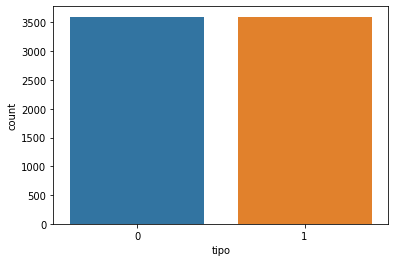

In [17]:
sns.countplot(dados_treinamento.tipo);

In [18]:
dados_treinamento.categoria.unique()

array(['politica', 'tv_celebridades', 'sociedade_cotidiano',
       'ciencia_tecnologia', 'economia', 'religiao', nan], dtype=object)

<AxesSubplot:xlabel='count', ylabel='categoria'>

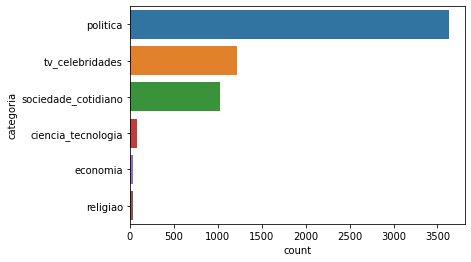

In [19]:
sns.countplot(y="categoria", data=dados_treinamento)

## Lipeza dos dados

In [20]:
dados = dados_treinamento # Mudei o nome para não confundir com o dados de treinamento do modelo de ML

In [21]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7200 entries, 0 to 1169
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   texto      7200 non-null   object
 1   tipo       7200 non-null   int64 
 2   autor      6030 non-null   object
 3   categoria  6030 non-null   object
 4   data       6030 non-null   object
dtypes: int64(1), object(4)
memory usage: 337.5+ KB


In [22]:
dados.drop(["autor", "categoria", "data"], axis=1, inplace=True)

In [23]:
dados.head()

,texto,tipo
0,﻿O Podemos decidiu expulsar o deputado federa...,1
1,"Bolsonaro é um liberal completo, diz president...",1
2,Ministro do STF libera Andrea Neves de prisão ...,1
3,"Apesar da abundância, cresce preocupação com p...",1
4,"Por que Harvard e MIT levarão Dilma, Moro e Su...",1


In [24]:
X = dados.iloc[:, 0].values

In [25]:
X

array(['\ufeffO Podemos decidiu  expulsar o deputado federal Carlos Gaguim do partido após a Polícia Federal fazer buscas a apreensões no gabinete dele na Câmara. Com isso, a legenda abre espaço para receber a senadora expulsa pelo PMDB, Katia Abreu. Por meio de nota, a legenda informou que o afastamento do parlamentar já era algo acordado entre os filiados da sigla.  “Ainda que o parlamentar tenha comunicado a conclusão de sua desfiliação para esta semana, diante dos fatos noticiados hoje, a Executiva Nacional do Podemos solicita o imediato cancelamento de sua filiação dos quadros do partido”.\n\nO partido, que no passado chegou a cogitar lançar o parlamentar como candidato ao Senado, diz que “apoia a investigação com a ampla apuração dos eventuais crimes cometidos e a consequente responsabilização dos envolvidos, para que todos sejam punidos com o máximo rigor da Lei, independentemente de posição ou cargo ocupado”. ',
       'Bolsonaro é um liberal completo, diz presidente do PSL\n\n

In [26]:
X.shape

(7200,)

In [27]:
type(X)

numpy.ndarray

In [28]:
todos_textos = "\n".join(X) # Junção de todos os textos 

In [29]:
wordcloud = WordCloud(width = 800, height = 400,
                background_color ='white',
                min_font_size = 10).generate(todos_textos)

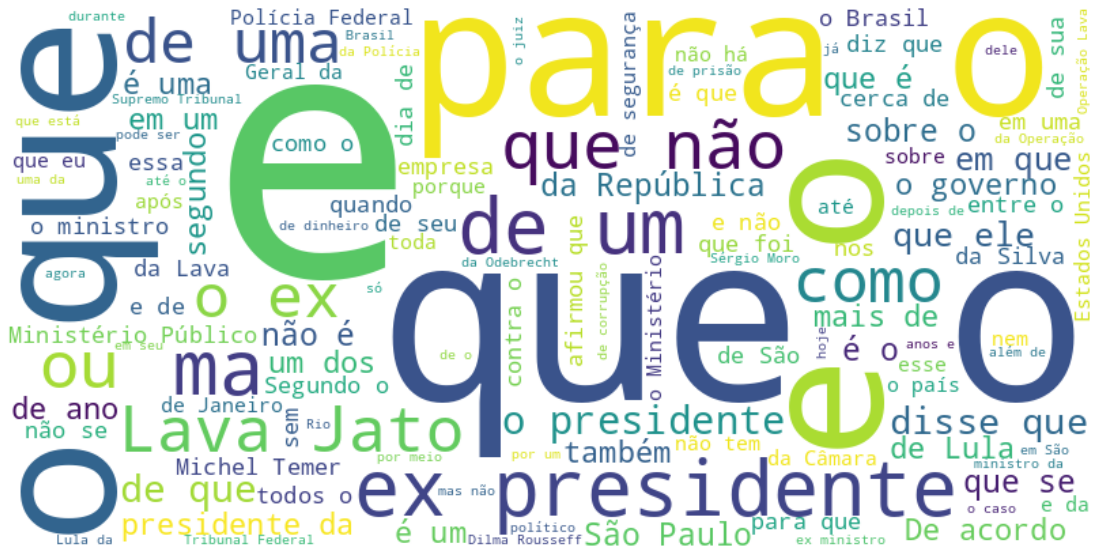

In [30]:
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordclou1.png', format='png')

## Retirada de stopwords

In [31]:
!python -m spacy download pt_core_news_sm

2022-06-27 15:28:30.313514: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-27 15:28:30.313560: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 5.5 MB/s eta 0:00:0000:0100:01
You should consider upgrading via the '/mnt/d/Projetos/tcc/projeto_de_tcc1/venv_tcc1/bin/python -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


In [32]:
nlp = sp.load("pt_core_news_sm")

In [33]:
stop_words = sp.lang.pt.STOP_WORDS

In [34]:
len(stop_words)

416

In [35]:
stop_words

{'a',
 'acerca',
 'ademais',
 'adeus',
 'agora',
 'ainda',
 'algo',
 'algumas',
 'alguns',
 'ali',
 'além',
 'ambas',
 'ambos',
 'antes',
 'ao',
 'aos',
 'apenas',
 'apoia',
 'apoio',
 'apontar',
 'após',
 'aquela',
 'aquelas',
 'aquele',
 'aqueles',
 'aqui',
 'aquilo',
 'as',
 'assim',
 'através',
 'atrás',
 'até',
 'aí',
 'baixo',
 'bastante',
 'bem',
 'boa',
 'bom',
 'breve',
 'cada',
 'caminho',
 'catorze',
 'cedo',
 'cento',
 'certamente',
 'certeza',
 'cima',
 'cinco',
 'coisa',
 'com',
 'como',
 'comprida',
 'comprido',
 'conhecida',
 'conhecido',
 'conselho',
 'contra',
 'contudo',
 'corrente',
 'cuja',
 'cujo',
 'custa',
 'cá',
 'da',
 'daquela',
 'daquele',
 'dar',
 'das',
 'de',
 'debaixo',
 'demais',
 'dentro',
 'depois',
 'des',
 'desde',
 'dessa',
 'desse',
 'desta',
 'deste',
 'deve',
 'devem',
 'deverá',
 'dez',
 'dezanove',
 'dezasseis',
 'dezassete',
 'dezoito',
 'diante',
 'direita',
 'disso',
 'diz',
 'dizem',
 'dizer',
 'do',
 'dois',
 'dos',
 'doze',
 'duas',
 'dá

In [36]:
len(X)

7200

In [37]:
t = np.array(10)

In [38]:
def excluir_quebras_linhas(texto):
    texto = texto.replace("\n", "")
    texto = texto.replace("\ufeffO", "")
    texto = texto.replace("\t", "")
    texto = texto.strip()
    return texto

def excluir_stop_word_pontuacao(texto):
    texto = texto.lower()
    documento = nlp(texto)
    
    palavras = []
    
    for token in documento:
        palavras.append(token.text)
        
    palavras = [palavra for palavra in palavras if palavra not in stop_words and palavra not in string.punctuation and palavra not in ["..."]]
    palavras = " ".join(palavras)
    return palavras

In [39]:
textos_limpos = [excluir_stop_word_pontuacao(excluir_quebras_linhas(texto)) for texto in X]

In [40]:
for _ in range(10):
    print(textos_limpos[random.randint(0, len(textos_limpos) - 1)])
    print("*" * 120)

após atendado jair bolsonaro houve tentativa eduardo bolsonaro unidassomosmaisfortes   aconteceu matar eduardo bolsonaro retirado seguranças houve tentativa mata-lo homem armado tenta matar eduardo bolsonaro seguranças agiram rápido militante esquerda tentou matar eduardo bolsonaro seguranças impediram informações posse pistola aconteceu campinas direito é possuir arma casa defesa porte arma além testes psicotécnicos curso tiro comprovação autorização porte já explicado várias hoje possuem armas 90 são armas ilegais registro são bandidos
************************************************************************************************************************
15 20 anos câncer doença controlada aids pesquisador inca especialista imunoterapia tratamentos avançados tumores joão viola fala evolução descobertas doença temida brasileiros ..   décadas 1980 1990 passou assombrar mundo intrigar cientistas aids causada vírus hiv altamente letal época doença tornou pesadelo filóso

In [41]:
todos_textos_limpos = "\n".join(textos_limpos)
wordcloud = WordCloud(width = 800, height = 400,
                background_color ='white',
                min_font_size = 10).generate(todos_textos_limpos)

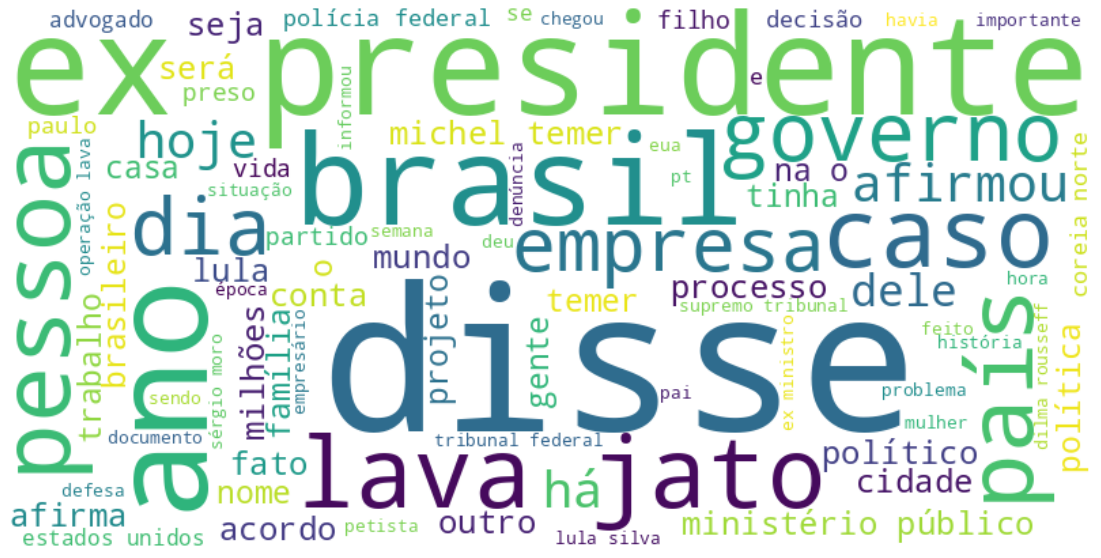

In [42]:
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordclou1.png', format='png')

In [43]:
y = dados.iloc[:, 1].values

In [44]:
y

array([1, 1, 1, ..., 0, 0, 0])

In [45]:
y.shape

(7200,)

In [46]:
rotulos_textos = y # cada texto foi rotulado com 0 (notícia falsa) e 1(notícia verdadeira)

In [47]:
rotulos_textos

array([1, 1, 1, ..., 0, 0, 0])

In [48]:
rotulos, quantidades = np.unique(rotulos_textos, return_counts=True)
rotulos, quantidades

(array([0, 1]), array([3600, 3600]))

## Tokenização

In [49]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(textos_limpos, target_vocab_size=2**16)

In [50]:
tokenizer.vocab_size

67880

In [51]:
ids = tokenizer.encode("Trabalho de Conclusão de Curso")

In [52]:
ids

[67708, 43019, 19852, 2383, 67691, 8499, 21627, 295, 944, 2383, 67691, 31090]

In [53]:
tokenizer.decode(ids)

'Trabalho de Conclusão de Curso'

In [203]:
dados_de_entrada = [tokenizer.encode(texto) for texto in textos_limpos]

In [204]:
len(dados_de_entrada[1])

493

In [205]:
len(dados_de_entrada[0])

82

## Padding

In [206]:
tamanho_maximo = max([len(texto_codificado) for texto_codificado in dados_de_entrada])
tamanho_maximo

4442

In [208]:
maior_texto_codificado = [texto_codificado for texto_codificado in dados_de_entrada if len(texto_codificado) == 4442]
tokenizer.decode(maior_texto_codificado[0])

"cartas democracia cubana   revolução cubana tenha feito invalidada desumana perseguição dela discordam moção grazziotin documento exalta imaginem compromisso cubano democracia justiça social amplamente divulgada brasileiros saibam gustavo guimarães veiga gjgveiga@hotmail.com paulo cubanos repetiram orgulho mote serviu propaganda força fins políticos regime comunista ilha noite muitas crianças morrerão fome será cubana hoje deveria acrescentado desfecho trágico àquele slogan ativista crianças cuba crescerão conscientizar-se-ão condição política preferirão morrer fome liberdade eugênio josé alati eugeniojosealati@yahoo.com.br campinas ideologia eleições colapso inexorável permitido concordar discordando será caso belo editorial esquerda derrota sarkozy 24/3 a3 sucede crepúsculo inexorável esquerda colapso anunciado bobbio fatos confirmando creio ideológicas razões tenham franceses infligido derrota presidente deterioram condições vida aumenta desemprego despenca economia votam eleitores

In [209]:
dados_de_entrada = tf.keras.preprocessing.sequence.pad_sequences(dados_de_entrada, 
                                                                 value=0, 
                                                                 padding='post', 
                                                                 maxlen=tamanho_maximo)

In [210]:
dados_de_entrada[:5]

array([[  858, 23074,     2, ...,     0,     0,     0],
       [  291,  4287,  3292, ...,     0,     0,     0],
       [   19,    63,  6646, ...,     0,     0,     0],
       [  257, 15288,  5332, ...,     0,     0,     0],
       [ 7403, 12222, 22573, ...,     0,     0,     0]], dtype=int32)

In [211]:
dados_de_entrada[:5][2].shape

(4442,)

## Divisão da base de dados em treinamento e teste

In [212]:
entradas_treino, entradas_teste, rotulos_treino, rotulos_teste = train_test_split(dados_de_entrada, 
                                                                                  rotulos_textos, 
                                                                                  test_size=0.3, 
                                                                                  stratify=rotulos_textos) 

In [213]:
entradas_treino[0]

array([  333, 67669,    26, ...,     0,     0,     0], dtype=int32)

In [214]:
entradas_treino.shape

(5040, 4442)

In [215]:
rotulos_treino.shape

(5040,)

In [216]:
entradas_teste.shape

(2160, 4442)

In [217]:
rotulos_teste.shape

(2160,)

# Contrução do Modelo

In [240]:
class Modelo(tf.keras.Model):
    
    def __init__(self,
                vocab_size,
                emb_dim=128,
                nr_filters=50,
                ffn_units=512,
                nr_classes=2,
                dropout_rate=0.1,
                training=False,
                name="modelo"):
        
        super(Modelo,self).__init__(name=name)
        
        # matrix de entrada de dados
        self.embedding = layers.Embedding(vocab_size, emb_dim)
        
        # camadas de convolução
        self.filtro_2_linhas = layers.Conv1D(filters=nr_filters, kernel_size=2, padding='same', activation='relu')
        self.filtro_3_linhas = layers.Conv1D(filters=nr_filters, kernel_size=3, padding='same', activation='relu')
        self.filtro_4_linhas = layers.Conv1D(filters=nr_filters, kernel_size=4, padding='same', activation='relu')
        
        # Camadas de pooling
        self.poll = layers.GlobalMaxPool1D()
         
        # Rede neural densa
        self.dense_1 = layers.Dense(units=ffn_units, activation = "relu")
        self.dropout = layers.Dropout(rate=dropout_rate)
        self.last_dense = layers.Dense(units = 1, activation = "sigmoid")
     
    def call(self, inputs, training):
        x = self.embedding(inputs)
        x_1 = self.filtro_2_linhas(x) 
        x_1 = self.poll(x_1)
        x_2 = self.filtro_3_linhas(x) 
        x_2 = self.poll(x_2)
        x_3 = self.filtro_4_linhas(x) 
        x_3 = self.poll(x_3)
        
        merged = tf.concat([x_1, x_2, x_3], axis = -1)
        merged = self.dense_1(merged)
        merged = self.dropout(merged, training)
        output = self.last_dense(merged)
        
        return output
        
        

# Treinamento

## Parâmetros de configuração da rede neural

In [241]:
tamanho_vocabulario = tokenizer.vocab_size
tamanho_vocabulario

67880

In [242]:
emb_dim = 200
nr_filters = 100
ffn_units = 256
nr_classes = len(set(rotulos_treino))
nb_classes

2

In [243]:
dropout_rate = 0.2
nr_epochs = 10
batch_size = 64

## Treinamento

In [244]:
modelo = Modelo(vocab_size=tamanho_vocabulario, 
            emb_dim=emb_dim, 
            nr_filters=nr_filters, 
            ffn_units=ffn_units,
            nr_classes=nr_classes, 
            dropout_rate=dropout_rate)

In [245]:
modelo.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [246]:
checkpoint_path = "./"
ckpt = tf.train.Checkpoint(Dcnn=modelo)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Latest checkpoint restored")
    


Latest checkpoint restored


In [227]:
history = modelo.fit(entradas_treino, rotulos_treino, batch_size=batch_size, epochs=nr_epochs, verbose=1, validation_split=0.10)
ckpt_manager.save()

Epoch 1/10
71/71 [==============================] - 215s 3s/step - loss: 0.2592 - accuracy: 0.8995 - val_loss: 0.0200 - val_accuracy: 0.9960
Epoch 2/10
71/71 [==============================] - 214s 3s/step - loss: 0.0104 - accuracy: 0.9974 - val_loss: 0.0132 - val_accuracy: 0.9960
Epoch 3/10
71/71 [==============================] - 205s 3s/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0067 - val_accuracy: 0.9960
Epoch 4/10
71/71 [==============================] - 217s 3s/step - loss: 3.6319e-04 - accuracy: 1.0000 - val_loss: 0.0065 - val_accuracy: 0.9960
Epoch 5/10
71/71 [==============================] - 207s 3s/step - loss: 1.9410e-04 - accuracy: 1.0000 - val_loss: 0.0060 - val_accuracy: 0.9960
Epoch 6/10
71/71 [==============================] - 206s 3s/step - loss: 1.3461e-04 - accuracy: 1.0000 - val_loss: 0.0055 - val_accuracy: 0.9980
Epoch 7/10
71/71 [==============================] - 206s 3s/step - loss: 7.5874e-05 - accuracy: 1.0000 - val_loss: 0.0055 - val_accuracy: 0.99

'./ckpt-1'

# Avaliação do modelo

## Avaliação

In [229]:
results = modelo.evaluate(entradas_teste, rotulos_teste, batch_size=batch_size)
print(results)

34/34 [==============================] - 22s 652ms/step - loss: 0.0320 - accuracy: 0.9884
[0.03195786476135254, 0.9884259104728699]


In [230]:
y_pred_test = modelo.predict(entradas_teste)

In [231]:
y_pred_test

array([[7.3882937e-04],
       [1.0210796e-06],
       [2.0530033e-10],
       ...,
       [2.0726435e-07],
       [9.9995553e-01],
       [5.7158879e-08]], dtype=float32)

In [232]:
y_pred_test = (y_pred_test > 0.5)

In [233]:
y_pred_test

array([[False],
       [False],
       [False],
       ...,
       [False],
       [ True],
       [False]])

In [234]:
rotulos_teste

array([0, 0, 0, ..., 0, 1, 0])

In [235]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(rotulos_teste, y_pred_test)
cm

array([[1071,    9],
       [  16, 1064]])

<AxesSubplot:>

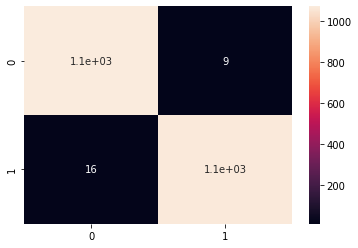

In [236]:
sns.heatmap(cm, annot=True)

In [237]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

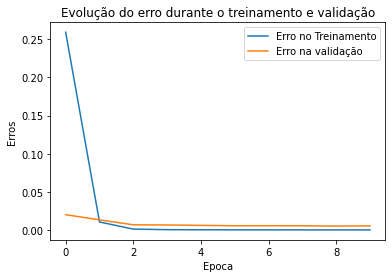

In [250]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Evolução do erro durante o treinamento e validação")
plt.xlabel("Epoca")
plt.ylabel("Erros")
plt.legend(["Erro no Treinamento", "Erro na validação"])

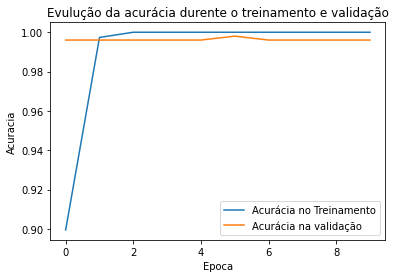

In [251]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Evulução da acurácia durente o treinamento e validação")
plt.xlabel("Epoca")
plt.ylabel("Acuracia")
plt.legend(["Acurácia no Treinamento", "Acurácia na validação"])